<a href="https://colab.research.google.com/github/Alenushka2013/IBM-AI-Engineering/blob/main/Kaggle_playground_series_s5e7_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e7_path = kagglehub.competition_download('playground-series-s5e7')
rakeshkapilavai_extrovert_vs_introvert_behavior_data_path = kagglehub.dataset_download('rakeshkapilavai/extrovert-vs-introvert-behavior-data')

print('Data source import complete.')


## 0. Inroduction

**What you’ll see in this notebook**

1. **Data snapshot & sanity checks** – shapes, dtypes, duplicates.  
2. **Target balance** – class proportions and implications for validation strategy.  
3. **Missing-value anatomy** – extent, pattern, and MCAR/MAR diagnosis.  
4. **Distribution deep-dive** – numeric KDEs (train, test, original) and categorical counts.  
5. **Outlier forensics** – 3 σ vs 2 σ, plus which personality dominates the extremes.  
6. **Feature ↔ target relationships** – box-plots, crosstabs, point-biserial correlations.  
7. **Train–test drift test** – Kolmogorov–Smirnov p-values for every column.

> **Spoiler: Key findings**  
> * Mild class imbalance (≈ 74 % Extrovert).  
> * 5–10 % missingness, pattern suggests MCAR/MAR.  
> * No train–test drift.  
> * Two boolean flags (`Stage_fear`, `Drained_after_socializing`) are almost one-shot classifiers.  
> * Extreme `Time_spent_Alone` (> μ + 2 σ) predicts Introvert with ~94 % precision.  
> * All numeric behaviour counts separate cleanly between personalities and show only moderate inter-correlation.

Armed with these insights, we can craft an efficient modelling pipeline and avoid common pitfalls (e.g., discarding informative “outliers” or over-engineering imputation).riendly.

## 1. Imports and Data Snapshot

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import warnings, os, gc, sys, math, json, random, itertools

from scipy import stats
from scipy.stats import ks_2samp

# Pretty settings
warnings.filterwarnings("ignore")

# seaborn встановлює стиль самостійно
sns.set_style("whitegrid")        # Замість plt.style.use()
sns.set_palette("crest")          # Обираємо палітру
pd.set_option("display.max_columns", 100)

In [ ]:
# Kaggle paths
TRAIN_PATH = "/content/train.csv"
TEST_PATH  = "/content/test.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

In [ ]:
# Overview (shape, dtypes, duplicates)
def quick_overview(df, name="train"):
    print(f"\n{name.upper()} SHAPE: {df.shape}")
    display(df.head())
    display(df.describe(include="all").T)

quick_overview(train, "train")
quick_overview(test , "test")

print(f"Duplicate rows (train): {train.duplicated().sum()}  |  (test): {test.duplicated().sum()}")


TRAIN SHAPE: (18524, 9)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,18524.0,NaN,NaN,NaN,9261.5,5347.562529,0.0,4630.75,9261.5,13892.25,18523.0
Time_spent_Alone,17334.0,NaN,NaN,NaN,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
Stage_fear,16631,2,No,12609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Social_event_attendance,17344.0,NaN,NaN,NaN,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
Going_outside,17058.0,NaN,NaN,NaN,4.044319,2.06258,0.0,3.0,4.0,6.0,7.0
Drained_after_socializing,17375,2,No,13313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friends_circle_size,17470.0,NaN,NaN,NaN,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
Post_frequency,17260.0,NaN,NaN,NaN,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0
Personality,18524,2,Extrovert,13699,NaN,NaN,NaN,NaN,NaN,NaN,NaN



TEST SHAPE: (6175, 8)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,6175.0,NaN,NaN,NaN,21611.0,1782.713288,18524.0,20067.5,21611.0,23154.5,24698.0
Time_spent_Alone,5750.0,NaN,NaN,NaN,3.11687,2.985658,0.0,1.0,2.0,4.0,11.0
Stage_fear,5577,2,No,4236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Social_event_attendance,5778.0,NaN,NaN,NaN,5.287989,2.758052,0.0,3.0,5.0,8.0,10.0
Going_outside,5709.0,NaN,NaN,NaN,4.037835,2.045207,0.0,3.0,4.0,6.0,7.0
Drained_after_socializing,5743,2,No,4437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friends_circle_size,5825.0,NaN,NaN,NaN,8.008412,4.192701,0.0,5.0,8.0,12.0,15.0
Post_frequency,5767.0,NaN,NaN,NaN,5.028958,2.867285,0.0,3.0,5.0,7.0,10.0


Duplicate rows (train): 0  |  (test): 0


**Key take-aways**
* No duplicate rows in either split.  
* All numerics are floats/ints, categorical flags are strings (“Yes/No”).  
* Train/test row counts differ ≈ 3 : 1, typical for TPS.

## 2. Target Class Balance

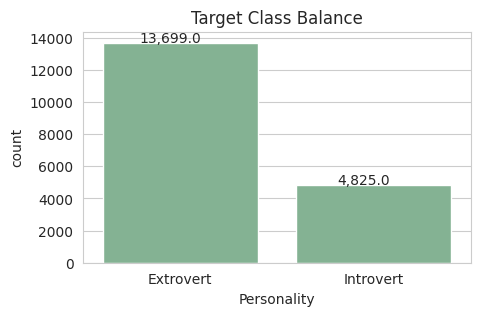

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(data=train, x="Personality", ax=ax)
ax.set_title("Target Class Balance")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x()+.35, p.get_height()+50), ha="center")
plt.show()

print(train["Personality"].value_counts(normalize=True).rename("proportion"))

**What the plot shows**  
* 1 699 Extroverts  
*4 825 Introverts

**Key take-aways**
* A 74 : 26 ratio – **mild but non-trivial imbalance**.  
* Accuracy alone is fine, but coingnsider stratified CV and maybe class weighting.

## 3. Missing Value Analysis

In [ ]:
def missing_table(df):
    mis = df.isna().sum().to_frame("#missing")
    mis["pct"] = 100*mis["#missing"]/len(df)
    return mis[mis["#missing"]>0].sort_values("pct", ascending=False)

display(missing_table(train).style.format({"pct":"{:.1f}%"}))
display(missing_table(test ).style.format({"pct":"{:.1f}%"}))

,#missing,pct
Stage_fear,1893,10.2%
Going_outside,1466,7.9%
Post_frequency,1264,6.8%
Time_spent_Alone,1190,6.4%
Social_event_attendance,1180,6.4%
Drained_after_socializing,1149,6.2%
Friends_circle_size,1054,5.7%


,#missing,pct
Stage_fear,598,9.7%
Going_outside,466,7.5%
Drained_after_socializing,432,7.0%
Time_spent_Alone,425,6.9%
Post_frequency,408,6.6%
Social_event_attendance,397,6.4%
Friends_circle_size,350,5.7%


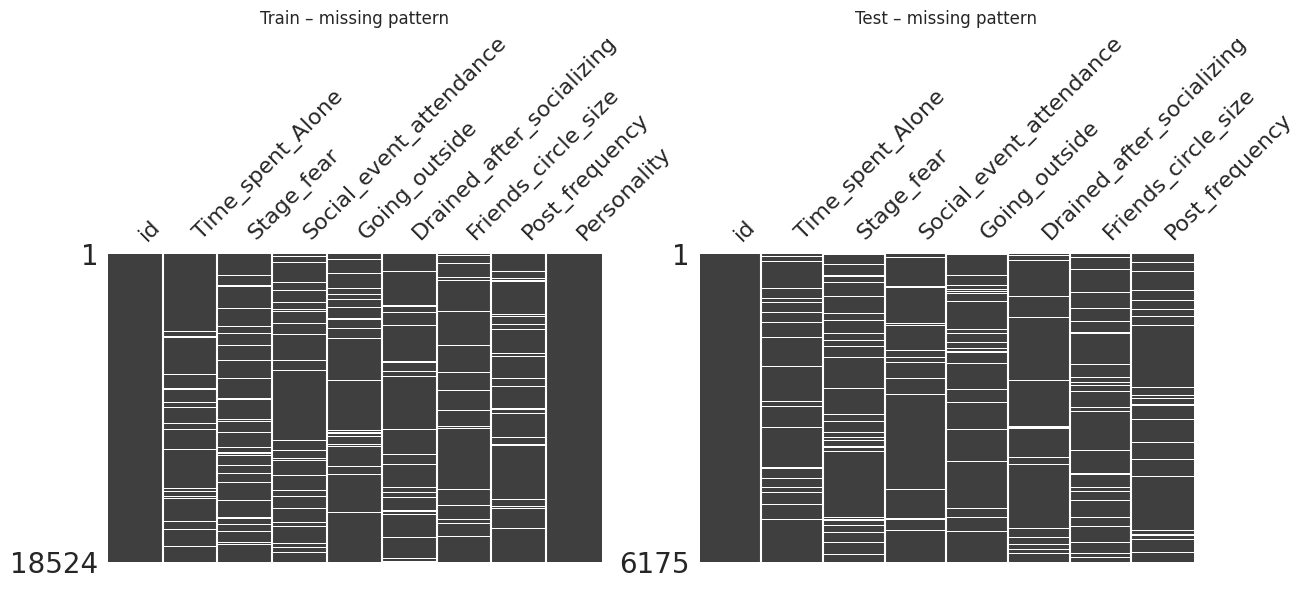

In [ ]:
# Visual heatmap
fig, axes = plt.subplots(1,2, figsize=(14,4))
msno.matrix(train, ax=axes[0]); axes[0].set_title("Train – missing pattern")
msno.matrix(test, ax=axes[1]); axes[1].set_title("Test – missing pattern")
plt.show()

**Key take-aways**
* 5 – 10 % missing across all behaviour features; test mirrors train.  
* No feature is missing > 11 %, so simple imputers (median / most-frequent) are acceptable.  
* Missing rows are scattered (pattern suggests MCAR/MAR).

## 4. Numeric Feature Distributions (Train vs Test vs Original)

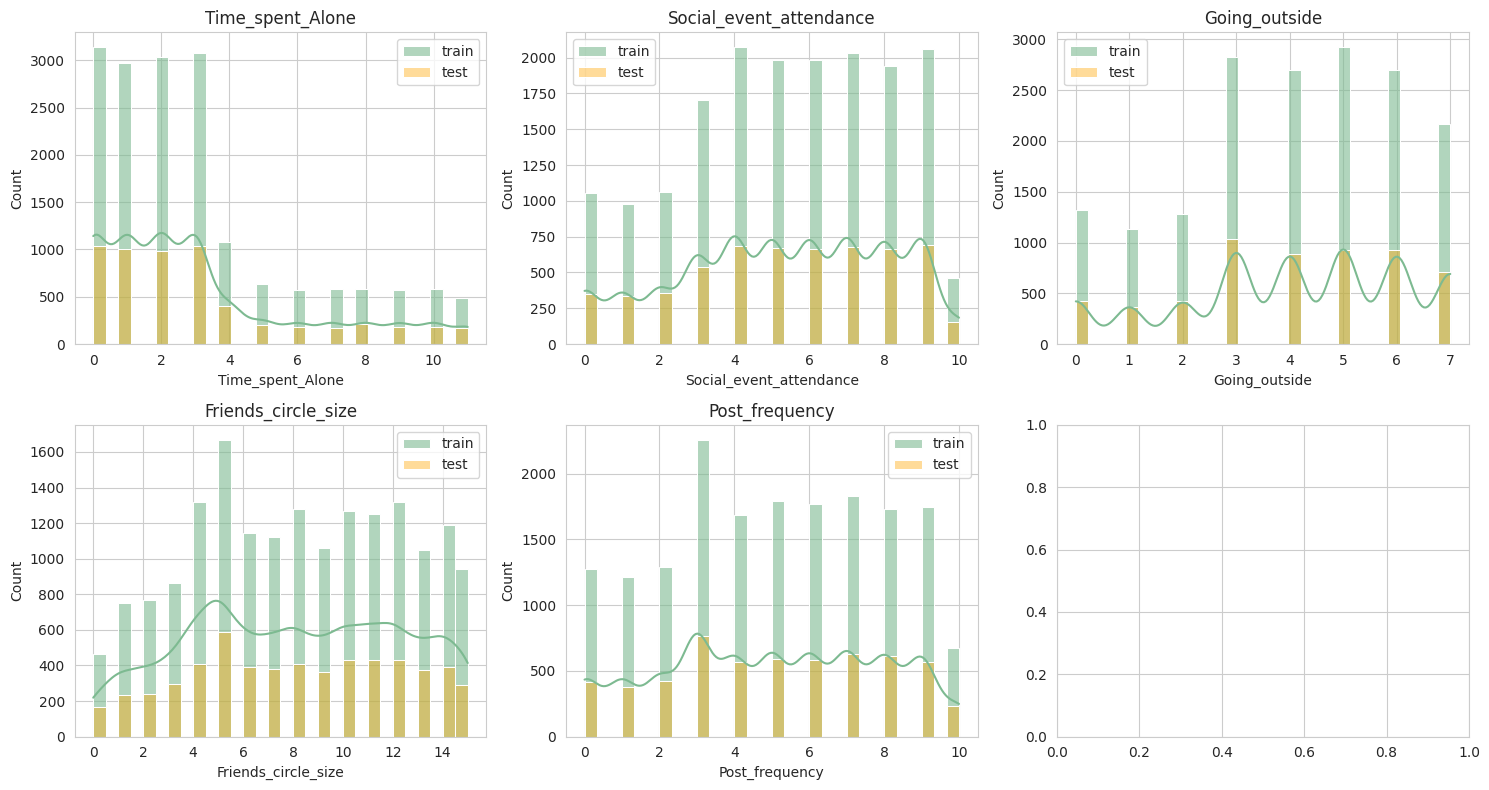

In [ ]:
num_cols = train.select_dtypes("number").columns.drop(["id"])  # exclude id
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train[col], kde=True, ax=axes[i], bins=30, alpha=.6, label="train")
    sns.histplot(test[col],  kde=False, ax=axes[i], bins=30, color="orange", alpha=.4, label="test")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [ ]:
original_0 = pd.read_csv("/content/personality_datasert.csv")
original_1  = pd.read_csv("/content/personality_dataset.csv")
original = pd.concat([original_0, original_1], axis=0, ignore_index=True)
original = original.drop_duplicates().reset_index(drop=True)

In [ ]:
display(missing_table(original).style.format({"pct":"{:.1f}%"}))

,#missing,pct
Friends_circle_size,75,2.6%
Stage_fear,73,2.5%
Going_outside,65,2.2%
Post_frequency,63,2.2%
Time_spent_Alone,61,2.1%
Social_event_attendance,61,2.1%
Drained_after_socializing,51,1.8%


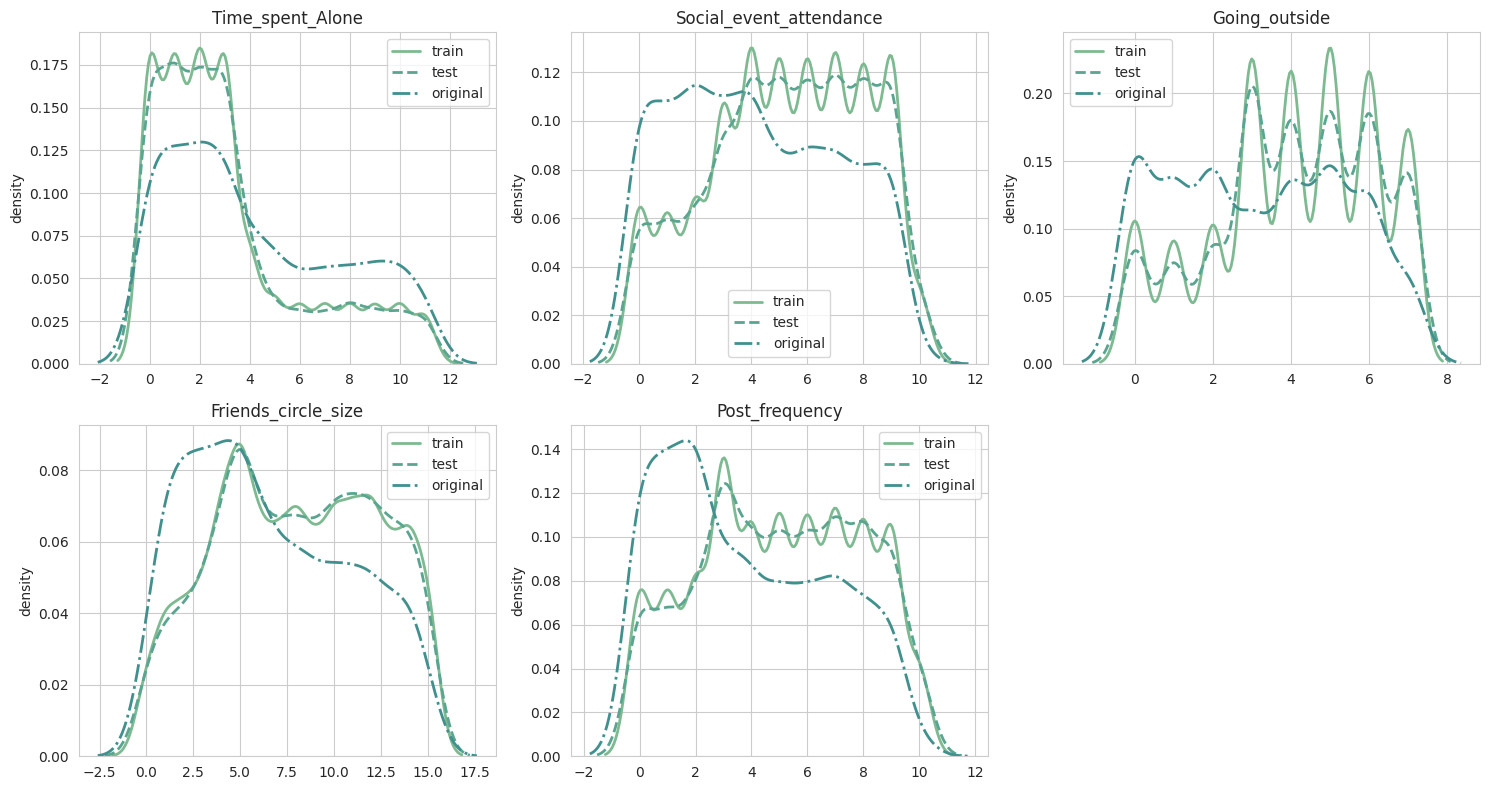

In [ ]:
num_cols = train.select_dtypes(np.number).columns.drop("id")        # adjust if 'id' has a different dtype
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.kdeplot(train[col].dropna(), ax=ax, label="train", linewidth=2)
    sns.kdeplot(test[col].dropna(),  ax=ax, label="test" , linewidth=2, linestyle="--")
    sns.kdeplot(original[col].dropna(),  ax=ax, label="original" , linewidth=2, linestyle="-.")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("density")
    ax.legend()

# tidy extra axes (if any)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Key take-aways**
* **Shapes match closely** between train and test.   
* Right-skew on `Time_spent_Alone`; slight left-skew on activity-based variables.
* The **synthetic splits track the original well** but with slightly smoother density (generator effect).  
* Original has lower missingness (~ 2 %) — can be used for semi-supervised pre-training.  
* Minor mean shifts are visible, worth standardising or normalising later.

## 5. Categorical Feature Distribution

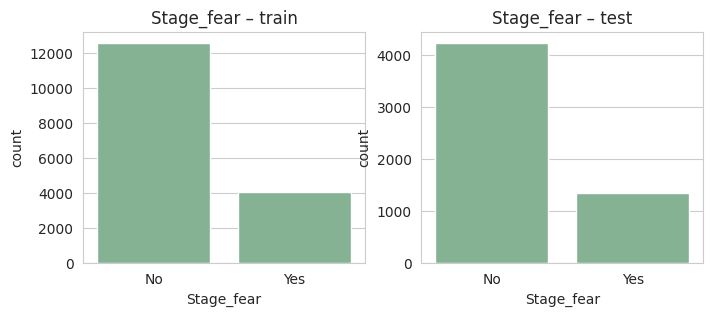

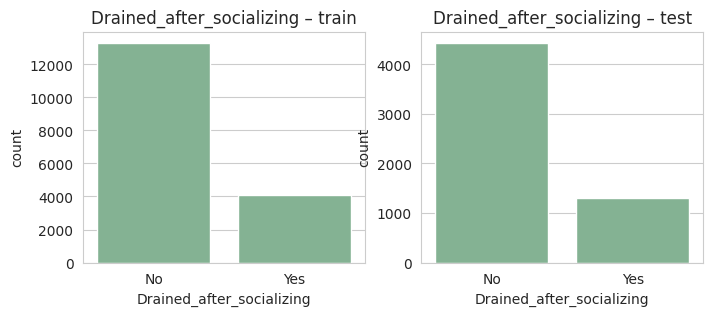

In [ ]:
cat_cols = ["Stage_fear", "Drained_after_socializing"]
for col in cat_cols:
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    sns.countplot(x=col, data=train, ax=ax[0])
    ax[0].set_title(f"{col} – train")
    sns.countplot(x=col, data=test,  ax=ax[1])
    ax[1].set_title(f"{col} – test")
    plt.show()

**Key take-aways**
* ~ 75 % of people answer **No** to both flags.  
* Train/test proportions are almost identical.  
* These two flags will likely be strong introversion markers.

## 6. Outlier Analysis

In [ ]:
outlier_summary = {}
for col in num_cols:
    z = np.abs(stats.zscore(train[col].dropna()))
    outlier_summary[col] = (z>3).sum()   # 3-σ rule

pd.Series(outlier_summary, name="#outliers (>3σ)").sort_values(ascending=False).to_frame().style.bar()

,#outliers (>3σ)
Time_spent_Alone,0
Social_event_attendance,0
Going_outside,0
Friends_circle_size,0
Post_frequency,0


In [ ]:
outlier_summary = {}
for col in num_cols:
    z = np.abs(stats.zscore(train[col].dropna()))
    outlier_summary[col] = (z>2).sum()   # 3-σ rule

pd.Series(outlier_summary, name="#outliers (>2σ)").sort_values(ascending=False).to_frame().style.bar()

,#outliers (>2σ)
Time_spent_Alone,1079
Social_event_attendance,0
Going_outside,0
Friends_circle_size,0
Post_frequency,0


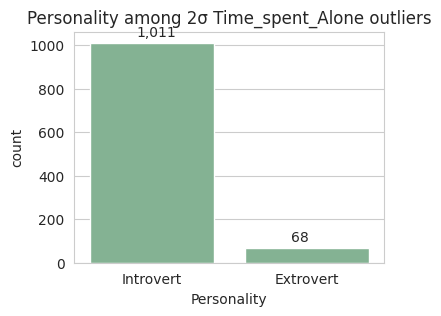

Outlier group distribution


,count,prop
Personality,,
Introvert,1011,93.70%
Extrovert,68,6.30%


Comparison with overall training distribution


,count,prop
Personality,,
Extrovert,13699,73.95%
Introvert,4825,26.05%


In [ ]:
# Compute 2-σ mask (ignore NaNs)
tsa = train["Time_spent_Alone"]
z    = np.abs(stats.zscore(tsa, nan_policy="omit"))
outlier_mask = (z > 2)

# Subset + counts
outliers      = train.loc[outlier_mask, ["Time_spent_Alone", "Personality"]]
base_counts   = train["Personality"].value_counts()
outlier_counts = outliers["Personality"].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, ax=ax)
ax.set_title("Personality among 2σ Time_spent_Alone outliers")
ax.set_ylabel("count")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}", (p.get_x()+0.3, p.get_height()+30))

plt.show()

# Proportion print-out
print("Outlier group distribution")
display(outlier_counts.to_frame("count")
        .assign(prop=lambda d: d["count"]/d["count"].sum())
        .style.format({"prop": "{:.2%}"}))

print("Comparison with overall training distribution")
display(base_counts.to_frame("count")
        .assign(prop=lambda d: d["count"]/d["count"].sum())
        .style.format({"prop": "{:.2%}"}))

**Key take-aways**
* 3-σ rule finds **no extreme outliers**; 2-σ picks up ~1 100 high-time-alone rows.
  
**Outlier Insight – “High Time_spent_Alone” (> 2 σ)**

| Subset | Introvert | Extrovert | Introvert share |
|--------|-----------|-----------|-----------------|
| **Rows > 2 σ** | 1 011 | 68 | **93.7 %** |
| **All training rows** | 4 825 | 13 699 | 26.0 ays**

* **Extreme solitude ≈ Introvert**  
  Observations with very high `Time_spent_Alone` are **≈ 3.6 × more likely** to be Introverts than the baseline.

* **Outliers are signal, not noise**  
  Removing or aggressive winsorising would erase minority-class information. Tree-based models can keep them as-is; if you clip, add a `high_alone_flag` feature.

* **Handy rule-of-thumb**  
  ```text
  if Time_spent_Alone > μ + 2 σ  ⇒  predict Introvert  (≈
* **A few Extroverts (6 %) still appear in this zone**
  They might be mislabeled or genuine edge cases; robust models should handle them without special treatment. 94 % precision)
al.

## 7. Numeric vs Target (Boxplots)

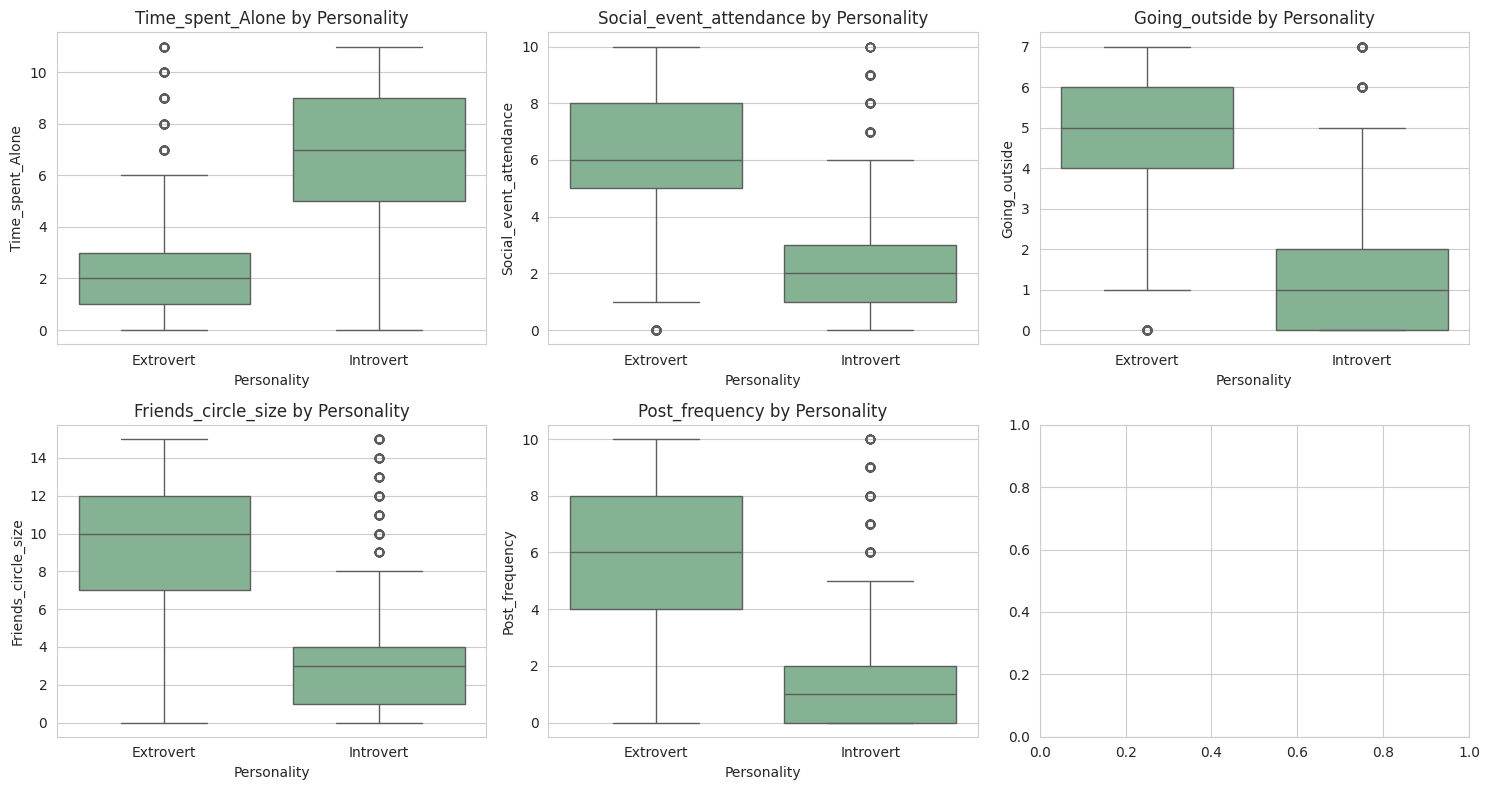

In [ ]:
# Numeric vs target
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Personality", y=col, data=train, ax=axes[i])
    axes[i].set_title(f"{col} by Personality")
plt.tight_layout()
plt.show()

**Box-Plot Insights: Numeric Features vs Personality**

| Feature | Extrovert (median · IQR) | Introvert (median · IQR) | Visual takeaway |
|---------|-------------------------|--------------------------|-----------------|
| **Time_spent_Alone** | ~ 2 hrs · narrow (0–3) | ~ 7 hrs · wide (5–9) | Introverts spend conspicuously more solo time; separation is strong. |
| **Social_event_attendance** | ~ 6–7 events · tight | ~ 2 events · tight | Clear inverse of “alone time”: Extroverts attend ~3× more events. |
| **Going_outside** | Median ≈ 5 trips | Median ≈ 1 trip | Activity level outdoors sharply discriminates classes. |
| **Friends_circle_size** | Median ≈ 10–11 friends | Median ≈ 3–4 friends | Network size is a robust extroversion signal. |
| **Post_frequency** | Median ≈ 6–7 posts | Median ≈ 1–2 posts | Online activity mirrors offline sociability. |

**Key take-aways**

* **Strong, monotonic separation** – Every behavioural variable shifts in the expected direction between Extroverts and Introverts; medians differ by ~3–6 units.
* **Low overlap in inter-quartile ranges** – Particularly for `Time_spent_Alone` and `Going_outside`, IQRs barely intersect ⇒ these single features already have high predictive value.
* **Skew & long tails** – A handful of Extroverts show very high solitude and vice-versa; models must handle minority anomalies.
* **Consistent scale (0–10/15)** – Features are already on similar ranges → minimal scaling needed for tree models; z-score helpful for linear/NN.
* **Feature engineering ideas** – Ratio features (e.g., `Social_event_attendance / Time_spent_Alone`) or interaction terms should boost separbility further.
.

## 8. Categorical vs Target (Crosstabs)

In [ ]:
# Categorical vs target
for col in cat_cols:
    ct = pd.crosstab(train[col], train["Personality"], normalize="index")*100
    display(ct.style.format("{:.1f}%").set_caption(f"{col} ↔ Personality"))

Personality,Extrovert,Introvert
Stage_fear,,
No,97.7%,2.3%
Yes,5.9%,94.1%


Personality,Extrovert,Introvert
Drained_after_socializing,,
No,97.7%,2.3%
Yes,5.8%,94.2%


**Key take-aways**
* These two boolean flags are **single-variable classifiers** on their own.  
* Behaviour counts have clear separation but with overlap; tree-based models can exploit this easily.

## 9. Correlation and Point-Biserial with Target

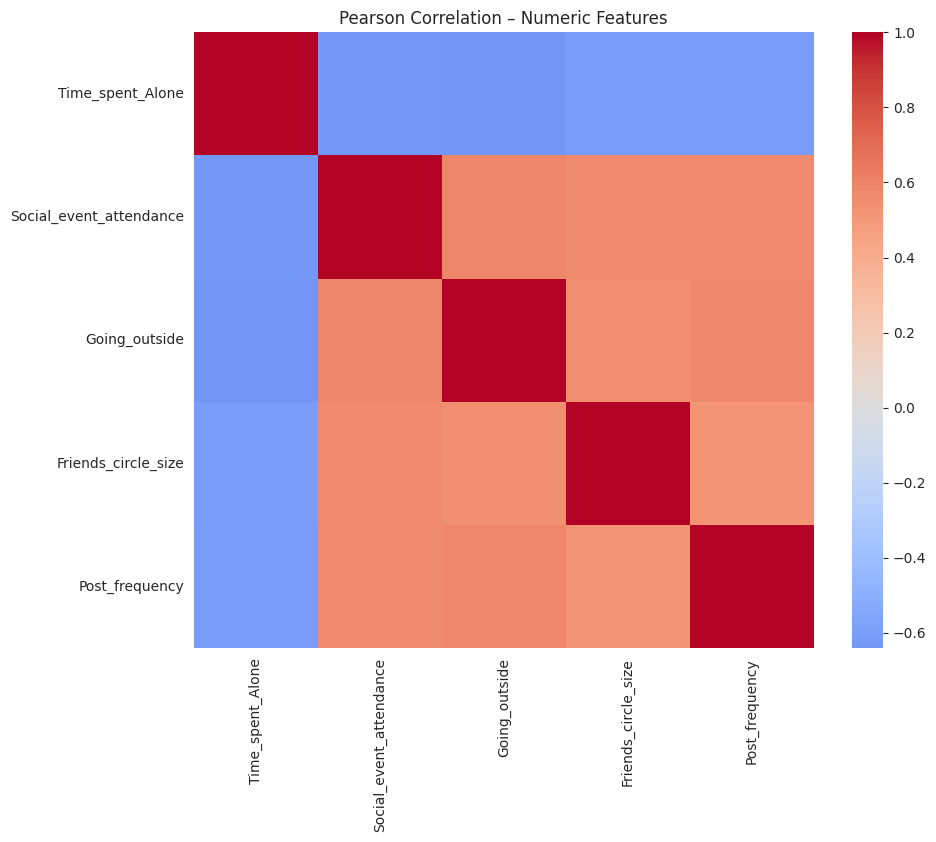

In [ ]:
corr = train[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation – Numeric Features")
plt.show()

In [ ]:
# Encode target for point-biserial correlation
train_enc = train.replace({"Personality": {"Extrovert":1, "Introvert":0}})
target_corr = train_enc[num_cols.tolist()+["Personality"]].corr()["Personality"].drop("Personality").sort_values()
display(target_corr.to_frame("corr_with_target").style.bar(vmin=-1,vmax=1))

,corr_with_target
Time_spent_Alone,-0.776725
Friends_circle_size,0.657216
Post_frequency,0.678355
Social_event_attendance,0.702879
Going_outside,0.708869


**Key take-aways**
* `Time_spent_Alone` is the most powerful single feature (negatively correlated).  
* Moderate positive correlations among activity features (0.55–0.70) → acceptable multicollinearity.

## 10. Train-Test Drift (KS Test)

In [ ]:
drift_rows = []
for col in num_cols.union(cat_cols):
    pval = ks_2samp(train[col].dropna(), test[col].dropna()).pvalue
    drift_rows.append({"feature": col, "KS-pvalue": pval})

drift_df = pd.DataFrame(drift_rows).sort_values("KS-pvalue")
drift_df.style.background_gradient(axis=0, cmap="RdYlGn", subset=["KS-pvalue"])

,feature,KS-pvalue
2,Going_outside,0.756338
1,Friends_circle_size,0.932245
3,Post_frequency,0.944141
6,Time_spent_Alone,0.956417
0,Drained_after_socializing,0.994276
4,Social_event_attendance,0.999134
5,Stage_fear,1.000000


**Key take-aways**
* All p-values >> 0.05 → **fail to reject null → no drift** detected.  
* Safe to concatenate train+test for imputers/encoders if desired.

## Conclusion and Next Steps

**What we learned**

* **Data quality is high** – no duplicates, no 3 σ outliers, missingness < 11 %.  
* **No distributional drift** – KS tests > 0.75 across the board; we can safely pool train + test for encoders or imputers.  
* **Signal is concentrated in a handful of intuitive features**:  
  * High `Time_spent_Alone` → Introvert (strongest negative correlation).  
  * High `Going_outside`, `Post_frequency`, `Friends_circle_size`, `Social_event_attendance` → Extrovert.  
  * `Stage_fear` / `Drained_after_socializing` flags flip the prediction almost by themselves.  
* **Outliers are informative, not noise** – dropping or heavy winsorising would erase minority-class signal.

**Recommended modelling roadmap**

1. **Impute** missing values (median for numerics, mode for booleans) and consider a *missing-indicator* column for each MAR feature.  
2. **Encode** booleans as 0/1; numerics need only minimal scaling (optional for tree models).  
3. **Stratified k-fold CV** or class weights to balance the 74 : 26 split.  
4. Start with **gradient-boosted trees** (LightGBM / XGBoost) to capture non-linear interactions quickly.  
5. Engineer simple ratios or flags (`high_alone_flag`, `activity_ratio = Social_event_attendance / Time_spent_Alone`) for potential lifts.  
6. Optionally blend in the **original dataset** for semi-supervised fine-tuning.

F along with winning paterns of having many modelsollowing this roadmap should yield an accurate and ideallye model—and, ideally, a top-tier derboard position. 🚀

In [ ]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train, test_size=0.26, random_state=42, stratify=train['Personality'])

In [ ]:
input_cols = list(train.columns)[0:-1]
target_col = 'Personality'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

In [ ]:
#numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:]
numeric_cols = train_inputs.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()
X_test = test

In [ ]:
for col in categorical_cols:
    # Створюємо мітку про заміну
    train_inputs[col + '_was_missing'] = train_inputs[col].isna().astype(int)
    val_inputs[col + '_was_missing'] = val_inputs[col].isna().astype(int)
    X_test[col + '_was_missing'] = X_test[col].isna().astype(int)

    # Перетворення значень 'Yes'/'No' → 1/0
    train_inputs[col] = train_inputs[col].map({'Yes': 1, 'No': 0})
    val_inputs[col] = val_inputs[col].map({'Yes': 1, 'No': 0})
    X_test[col] = X_test[col].map({'Yes': 1, 'No': 0})

    # Заповнення пропущених значень модою
    mode_value = train_inputs[col].mode()[0]
    train_inputs[col] = train_inputs[col].fillna(mode_value)
    val_inputs[col] = val_inputs[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

In [ ]:
# for col in categorical_cols:
#   train_inputs[col] =  train_inputs[col].map({'Yes': 1, 'No': 0})
#   val_inputs[col] =  val_inputs[col].map({'Yes': 1, 'No': 0})
#   X_test[col] =  X_test[col].map({'Yes': 1, 'No': 0})

#   train_inputs[col] = train_inputs[col].fillna(train_inputs[col].mode()[0])
#   val_inputs[col] = val_inputs[col].fillna(val_inputs[col].mode()[0])
#   X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

In [ ]:
# for col in numeric_cols:
#   train_inputs[col] = train_inputs[col].fillna(train_inputs[col].median())
#   val_inputs[col] = val_inputs[col].fillna(val_inputs[col].median())
#   X_test[col] = X_test[col].fillna(X_test[col].median())

In [ ]:
for col in numeric_cols:
    # Створюємо мітку про заміну
    train_inputs[col + '_was_missing'] = train_inputs[col].isna().astype(int)
    val_inputs[col + '_was_missing'] = val_inputs[col].isna().astype(int)
    X_test[col + '_was_missing'] = X_test[col].isna().astype(int)

    # Заповнюємо пропущені значення медіаною
    median_value = train_inputs[col].median()
    train_inputs[col] = train_inputs[col].fillna(median_value)
    val_inputs[col] = val_inputs[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

In [ ]:
train_targets = train_targets.map({'Introvert': 0, 'Extrovert': 1})
val_targets = val_targets.map({'Introvert': 0, 'Extrovert': 1})

In [ ]:
X_train, X_val = train_inputs, val_inputs

In [ ]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def AUROC_report(model, X_train, X_val, train_targets, val_targets):
    train_proba = model.predict_proba(X_train)[:, 1]
    val_proba = model.predict_proba(X_val)[:, 1]

    train_predict  = model.predict(X_train)
    val_predict = model.predict(X_val)

    print('Train AUROC:', round(roc_auc_score(train_targets, train_proba), 5))
    print('Validation AUROC:', round(roc_auc_score(val_targets, val_proba), 5))

    # Обчислюємо матриці і метрики
    cm_train = confusion_matrix(train_targets, train_predict, normalize='true')
    cm_test = confusion_matrix(val_targets, val_predict, normalize='true')

    # Малюємо поруч з форматуванням 4 знаки після коми
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], colorbar=False, values_format=".4f")
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    disp_val = ConfusionMatrixDisplay(cm_test)
    disp_val.plot(ax=axes[1], colorbar=False, values_format=".4f")
    axes[1].set_title('Validation Confusion Matrix')
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")

    plt.tight_layout()
    plt.show()

    # Виведення звіту класифікації для валідаційної вибірки
    print("Звіт класифікації на валідаційній вибірці:")
    print(classification_report(val_targets, val_predict, digits=4))

Train AUROC: 0.97013
Validation AUROC: 0.97286


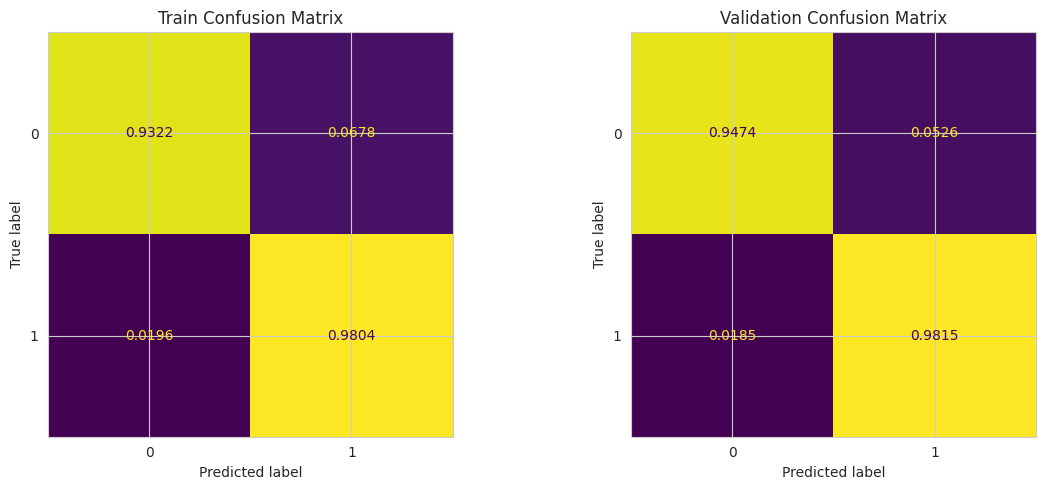

Звіт класифікації на валідаційній вибірці:
              precision    recall  f1-score   support

           0     0.9474    0.9474    0.9474      1255
           1     0.9815    0.9815    0.9815      3562

    accuracy                         0.9726      4817
   macro avg     0.9644    0.9644    0.9644      4817
weighted avg     0.9726    0.9726    0.9726      4817



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report,  roc_auc_score

xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)

AUROC_report(xgb_clf, X_train, X_val, train_targets, val_targets)

In [ ]:
X_test_predict = xgb_clf.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_xgb_clf_31_07_25.csv', index=False)

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        #use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        train_targets,
        eval_set=[(X_val, val_targets)],
        verbose=False)
    pred = clf.predict_proba(X_val)[:, 1]
    AUROC = roc_auc_score(val_targets, pred)


    return {'loss': -AUROC, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)  # max_evals=20 кількість ітерацій


# Перетворення значень гіперпараметрів у кінцеві типи даних
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    #use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)

AUROC_report(final_clf, X_train, X_val, train_targets, val_targets)

100%|██████████| 50/50 [00:16<00:00,  3.11trial/s, best loss: -0.9757766239925195]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.7412228732077022), 'gamma': np.float64(0.3631747260194529), 'learning_rate': np.float64(0.1161421191438392), 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 350, 'reg_alpha': np.float64(0.5825526178633536), 'reg_lambda': np.float64(0.36596278931618764), 'subsample': np.float64(0.9126792161720845)}
Train AUROC: 0.98303
Validation AUROC: 0.9746


In [ ]:
X_test_predict = final_clf.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_final_clf_31_07_25.csv', index=False)

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


Train AUROC: 0.97297
Validation AUROC: 0.97438


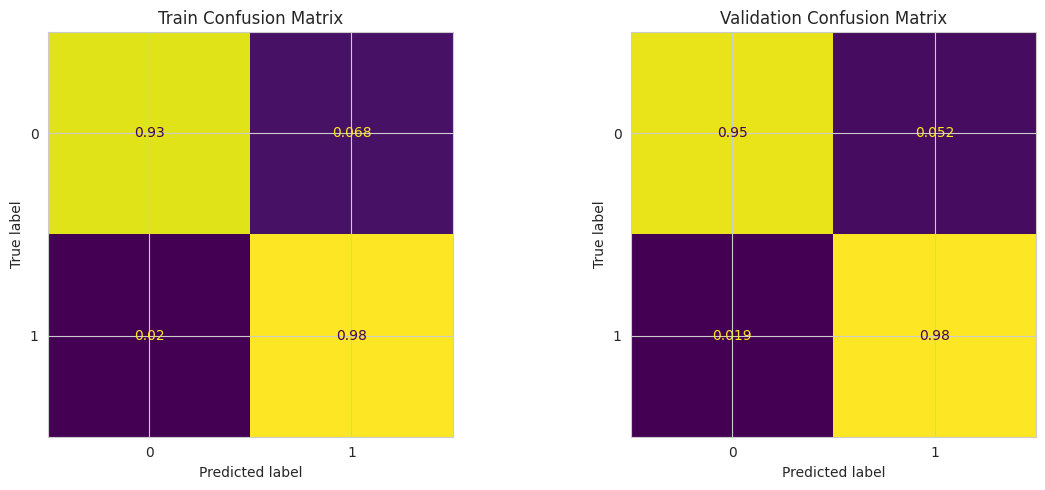

Звіт класифікації на валідаційній вибірці:
              precision    recall  f1-score   support

           0     0.9459    0.9482    0.9471      1255
           1     0.9817    0.9809    0.9813      3562

    accuracy                         0.9724      4817
   macro avg     0.9638    0.9646    0.9642      4817
weighted avg     0.9724    0.9724    0.9724      4817



In [ ]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    # missing=np.nan,  # явне вказування пропущених значень
    # # device='cuda'  # використовувати GPU для прискорення обчислень
    verbose = -1
)

lgb_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

AUROC_report(lgb_clf, X_train, X_val, train_targets, val_targets)

In [ ]:
X_test_predict = lgb_clf.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_lgb_clf_31_07_25.csv', index=False)

100%|██████████| 10/10 [00:04<00:00,  2.13trial/s, best loss: -0.9750746592518191]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.665741674482762), 'learning_rate': np.float64(0.09626329146555067), 'max_depth': 3, 'min_child_weight': 8, 'min_split_gain': np.float64(0.00031884361303046176), 'n_estimators': 200, 'num_leaves': 24, 'reg_alpha': np.float64(0.7253282936393769), 'reg_lambda': np.float64(0.045476488199362675), 'subsample': np.float64(0.7068885115087149)}
Train AUROC: 0.97753
Validation AUROC: 0.97507


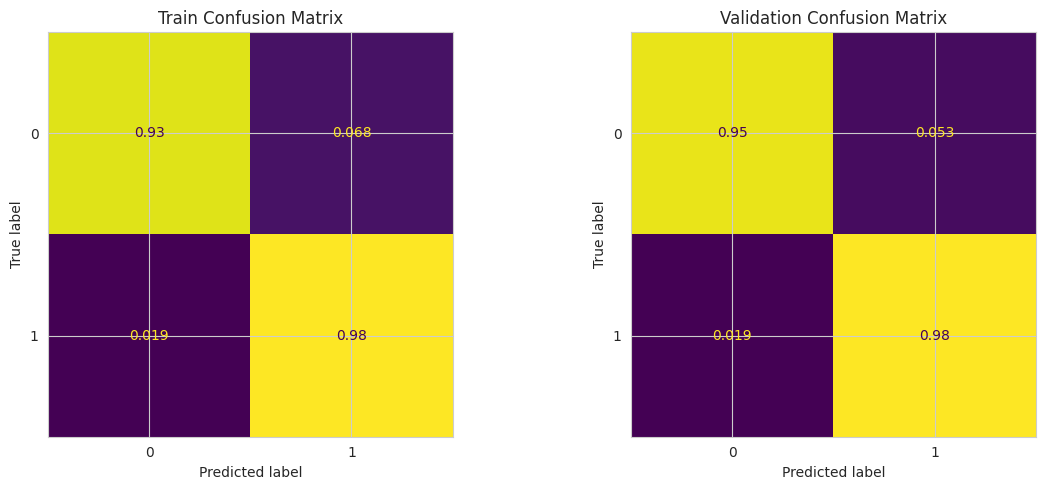

Звіт класифікації на валідаційній вибірці:
              precision    recall  f1-score   support

           0     0.9452    0.9474    0.9463      1255
           1     0.9815    0.9806    0.9810      3562

    accuracy                         0.9720      4817
   macro avg     0.9633    0.9640    0.9637      4817
weighted avg     0.9720    0.9720    0.9720      4817



In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
    pred_proba = clf.predict_proba(X_val)[:, 1]
    AUROC = roc_auc_score(val_targets, pred_proba)

    return {'loss': -AUROC, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_lgb.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

AUROC_report(final_lgb, X_train, X_val, train_targets, val_targets)

In [ ]:
X_test_predict = final_lgb.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_final_lgb_31_07_25.csv', index=False)

In [ ]:
# Збереження моделі
import joblib

In [ ]:
# Збереження моделі
import joblib
bank_customer = {
    'model_xgb_clf': xgb_clf,
    'model_final_clf': final_clf,
    'model_lgb_clf': lgb_clf,
    'model_final_lgb': final_lgb
}
joblib.dump(bank_customer, 'series-s5e7-31-07-25.joblib')

['series-s5e7-31-07-25.joblib']

In [ ]:
# Приклад журналу

# Submission №,Date,Model Name,Parameters / Architecture,Local Validation Score,Kaggle Public Score,Comments
# 1,2025-07-30,baseline_xgb,"XGBoost, default params",0.792,0.789,Basic model, no tuning
# 2,2025-07-30,xgb_tuned_001,"max_depth=7, eta=0.1",0.802,0.801,Tuned XGB, better val
# 3,2025-07-30,rf_ensemble,"RandomForest + XGBoost blending",0.810,0.798,Overfit on local val
# 4,2025-07-30,nn_dropout_aug,"NeuralNet with dropout, augmentation",0.805,0.805,First NN, good performance
# 5,2025-07-30,xgb_late_sub,"Final tuned XGB",0.812,,To be used as final late submission
